In [128]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional

In [129]:
def rot_x(theta: float) -> np.ndarray:
    return np.array(
        [
            [1, 0, 0, 0],
            [0, np.cos(theta), -np.sin(theta), 0],
            [0, np.sin(theta), np.cos(theta), 0],
            [0, 0, 0, 1]
        ]
    )

def rot_y(theta: float) -> np.ndarray:
    return np.array(
        [
            [np.cos(theta), 0, np.sin(theta), 0],
            [0, 1, 0, 0],
            [-np.sin(theta), 0, np.cos(theta), 0],
            [0, 0, 0, 1]
        ]
    )

def rot_z(theta: float) -> np.ndarray:
    return np.array(
        [
            [np.cos(theta), -np.sin(theta), 0, 0],
            [np.sin(theta), np.cos(theta), 0, 0],
            [0, 0, 1, 0],
            [0, 0, 0, 1]
        ]
    )

def translate_x(d: float) -> np.ndarray:
    res = np.eye(4)
    res[0, 3] = d
    return res

def translate_y(d: float) -> np.ndarray:
    res = np.eye(4)
    res[1, 3] = d
    return res

def translate_z(d: float) -> np.ndarray:
    res = np.eye(4)
    res[2, 3] = d
    return res

def forward_direct(h_1: float, h_2: float, h_3: float, *qs: float) -> list[np.ndarray]:
    # forward kinematics with frame positions as on the picture in the attached report
    t_a = rot_z(qs[0])
    t_b = t_a @ translate_z(h_1) @ rot_x(qs[1])
    t_c = t_b @ translate_y(h_2 + qs[2])
    t_d = t_c @ rot_y(qs[3])
    t_e = t_d @ rot_x(qs[4])
    t_f = t_e @ rot_y(qs[5]) @ translate_y(h_3)
    return [t_a, t_b, t_c, t_d, t_e, t_f]

def forward(h_1: float, h_2: float, h_3: float, *qs: float) -> list[np.ndarray]:
    # forward kinematics with frame non-corresponding origins (equivalent)
    t_a = translate_z(0.5 * h_1) @ rot_z(qs[0])
    t_b = t_a @ translate_z(0.5 * h_1) @ rot_x(qs[1])
    t_c = t_b @ translate_y(0.5 * h_2 + qs[2])
    t_d = t_c @ translate_y(0.25 * h_2) @ rot_y(qs[3])
    t_e = t_d @ translate_y(0.25 * h_2) @ rot_x(qs[4])
    t_f = t_e @ rot_y(qs[5]) @ translate_y(h_3)
    return [t_a, t_b, t_c, t_d, t_e, t_f]


# proof the frames placement form the equivalent systems
for random_qs in np.random.rand(1000, 6):
    random_hs = np.random.rand(3)
    random_ts_d = forward_direct(*random_hs, *random_qs)
    random_ts = forward_direct(*random_hs, *random_qs)
    for i in [1, -2, -1]:
        assert np.abs(random_ts[i] - random_ts_d[i]).sum() < 1e-6

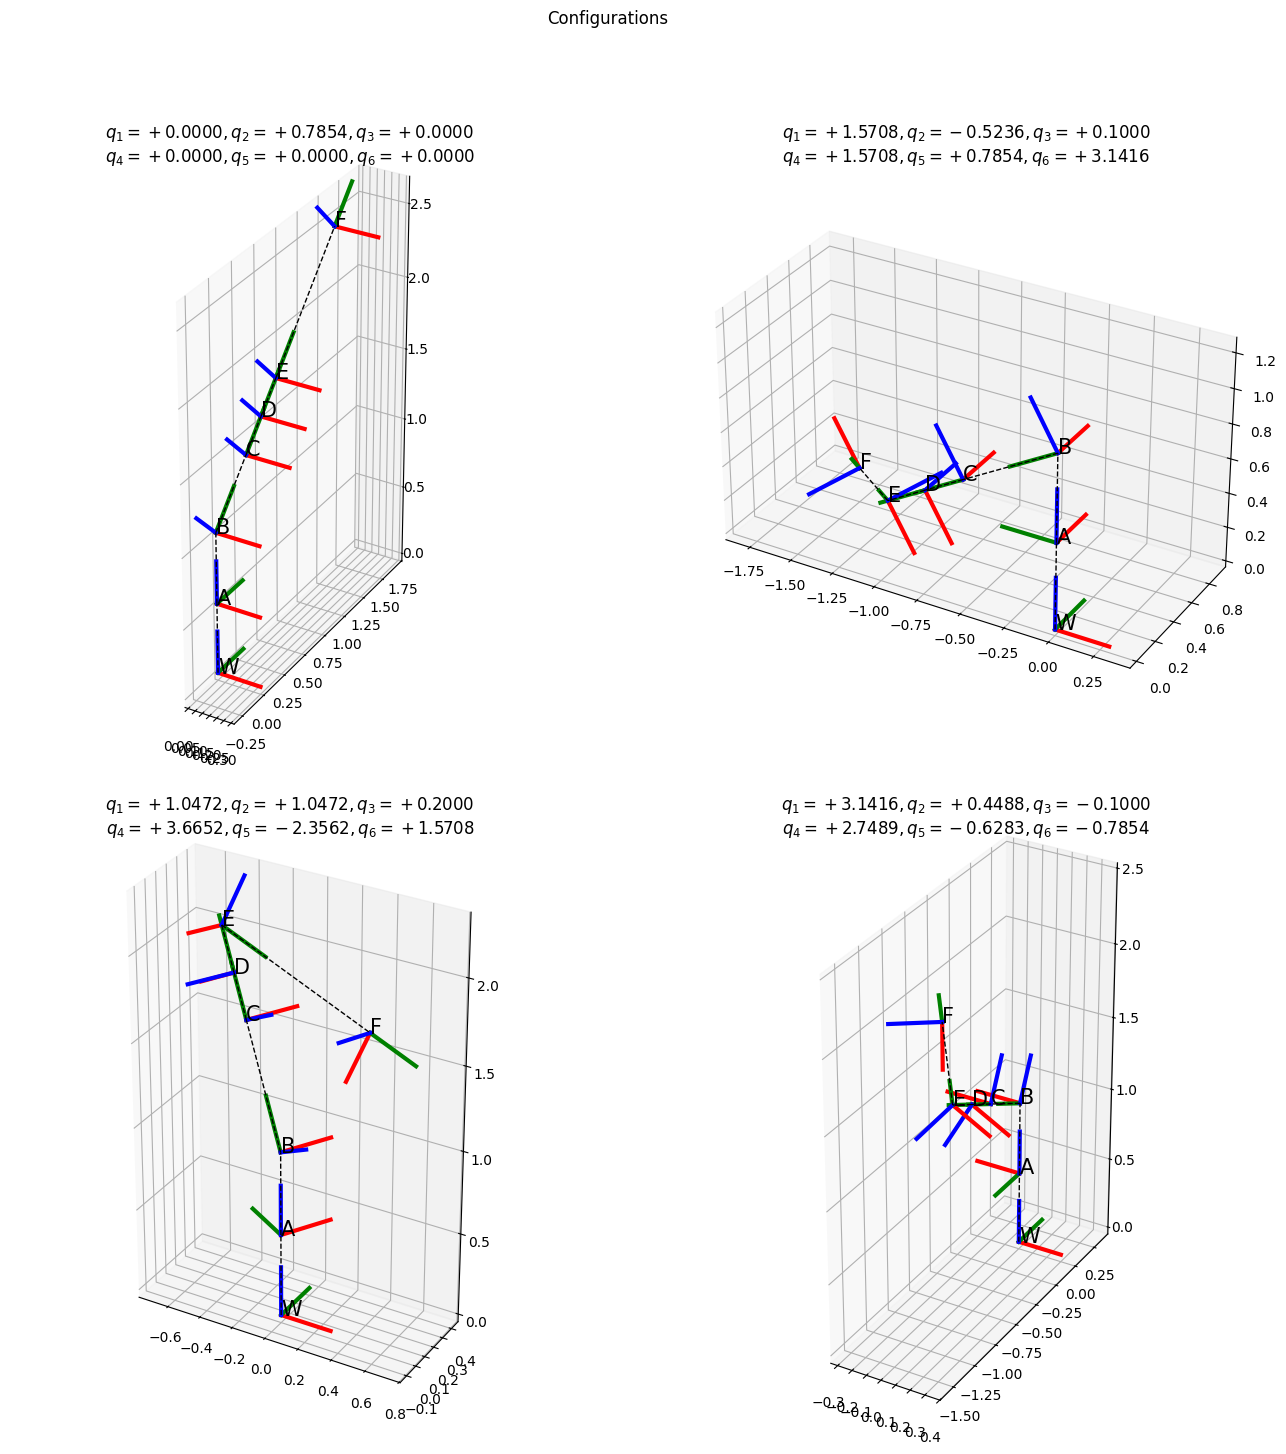

In [130]:
def plot_configuration(ts: np.ndarray, axes_scale: float = 0.3, ax: Optional[plt.Axes] = None):
    ax_given = bool(ax)
    ax = ax or plt.figure().add_subplot(projection='3d')
    axes_c = ["r", "g", "b"]

    # World frame
    world = np.eye(3)
    for i, c in zip(range(3), axes_c):
        ax.plot(
            *np.c_[np.zeros(3), axes_scale * world[:,i]],
            color=c, 
            linewidth=3,
        )

    # Joint frames
    for t in ts:
        for i, c in zip(range(3), axes_c):
            ax.plot(
                *np.c_[t[:3, -1], axes_scale * t[:3, i] + t[:3, -1]],
                color=c, 
                linewidth=3,
            )

    # Lines
    ax.plot(
        *np.c_[np.zeros(3), ts[0][:3, -1]],
        "--",
        color="black", 
        linewidth=1,
    )
    for t_prev, t_next in zip(ts, ts[1:]):
        ax.plot(
            *np.c_[t_prev[:3, -1], t_next[:3, -1]],
            "--",
            color="black", 
            linewidth=1,
        )

    ax.text(0, 0, 0, "W", color="black", fontsize=15)
    for text, t in zip(list("ABCDEF"), ts):
        ax.text(*t[:3, -1], text, color="black", fontsize=15)
    ax.set_box_aspect([u - l for l, u in (getattr(ax, f'get_{a}lim')() for a in 'xyz')])
    if not ax_given:
        plt.show()

H_1, H_2, H_3 = 1, 1, 1
EPSILON = 1e-4
CONFIGURATIONS = [
    np.array([0, np.pi / 4, 0, 0, 0, 0]),
    np.array([np.pi / 2, -np.pi / 6, 0.1, np.pi / 2, np.pi / 4, np.pi]),
    np.array([np.pi / 3, np.pi / 3, 0.2, 7 * np.pi / 6, -3 * np.pi / 4, np.pi / 2]),
    np.array([np.pi, np.pi / 7, -0.1, 7 * np.pi / 8, -np.pi / 5, -np.pi / 4]),
]

def signed_float(v: float, n: int) -> str:
    prefix = "+" if v >= 0 else "-"
    return f"{prefix}{abs(v):.4f}"

def configuration2str(qs: np.ndarray, split_by_newline: bool = True) -> str:
    a_1 = ", ".join(f"q_{i + 1} = {signed_float(v, 4)}" for i, v in enumerate(qs[:3]))
    a_2 = ", ".join(f"q_{i + 4} = {signed_float(v, 4)}" for i, v in enumerate(qs[3:]))
    if split_by_newline:
        return f"${a_1}$\n${a_2}$"
    return f"${a_1}, {a_2}$"

def plot_configurations(rows: int, 
                        columns: int, 
                        configurations: list[np.ndarray],
                        title: str,
                        save_as: str,
                        figsize: Optional[tuple[int, int]] = None):
    assert rows * columns == len(configurations)

    figsize = figsize or (16, 16)
    fig = plt.figure(figsize=figsize)
    fig.suptitle(title)
    for i in range(rows):
        for j in range(columns):
            qs = configurations[i * columns + j]
            if qs is None:
                continue
            t_frames = forward(H_1, H_2, H_3, *qs)
            ax = fig.add_subplot(rows, columns, i * columns + j + 1, projection='3d')
            plot_configuration(t_frames, ax=ax)
            ax.set_title(configuration2str(qs))

    plt.savefig(save_as, bbox_inches="tight")
    plt.show()

plot_configurations(2, 2, CONFIGURATIONS, "Configurations", "forward_configurations.png")

In [131]:
def backward(t_f: np.ndarray, h_1: float, h_2: float, h_3: float, epsilon: float):
    r_b = np.array([0, 0, h_1, 1])
    r_e = t_f.dot(np.array([0, -h_3, 0, 1]))
    q_1 = np.arctan2(r_e[1], r_e[0]) - np.pi / 2
    q_2 = np.arctan2(r_e[2] - h_1, np.sqrt(r_e[0]**2 + r_e[1]**2))
    q_3 = np.linalg.norm(r_e - r_b) - h_2

    j_b = ((r_e - r_b) / np.linalg.norm(r_e - r_b))[:3]
    j_e = t_f[:3, 1]  # corresponds with j_f
    j_f = t_f[:3, 1]
    i_b = rot_z(q_1)[:3, 0]
    i_f = t_f[:3, 0]

    if np.abs(j_b.dot(j_e)) > 1 - epsilon:
        print("Undefined position of E frame, choosing the closest")
        i_e = np.array(i_b)
        undefined_e = True
    else:
        i_e = np.cross(j_b, j_e)
        i_e /= np.linalg.norm(i_e)
        undefined_e = False

    q_4_1 = np.sign(np.cross(i_b, i_e).dot(j_b)) * np.arccos(i_b.dot(i_e))
    q_4_2 = np.sign(np.cross(i_b, -i_e).dot(j_b)) * np.arccos(-i_b.dot(i_e))
    q_5_1 = np.arccos(j_b.dot(j_e))
    q_5_2 = -np.arccos(j_b.dot(j_e))
    q_6_1 = np.sign(np.cross(i_e, i_f).dot(j_b)) * np.arccos(i_e.dot(i_f))
    q_6_2 = np.sign(np.cross(-i_e, i_f).dot(j_b)) * np.arccos(-i_e.dot(i_f))

    if undefined_e:
        return (np.array([q_1, q_2, q_3, q_4_1, q_5_1, q_6_1]),)

    return np.array([q_1, q_2, q_3, q_4_1, q_5_1, q_6_1]), np.array([q_1, q_2, q_3, q_4_2, q_5_2, q_6_2])


def test_backward():
    sample_qs = 2 * np.random.rand(6) - 1
    sample_ts = forward(H_1, H_2, H_3, *sample_qs)

    backward_qs = backward(sample_ts[-1], H_1, H_2, H_3, 0.1 * EPSILON ** 2)
    backward_ts = [forward(H_1, H_2, H_3, *qs) for qs in backward_qs]

    total_error = np.mean(
        [np.abs(ts[-1] - sample_ts[-1]).sum() for ts in backward_ts]
    )
    if total_error >= EPSILON:
        print(total_error)
    assert total_error < EPSILON

# Check that backward algorithm works
for i in range(10000):
    test_backward()

Undefined position of E frame, choosing the closest


Undefined position of E frame, choosing the closest


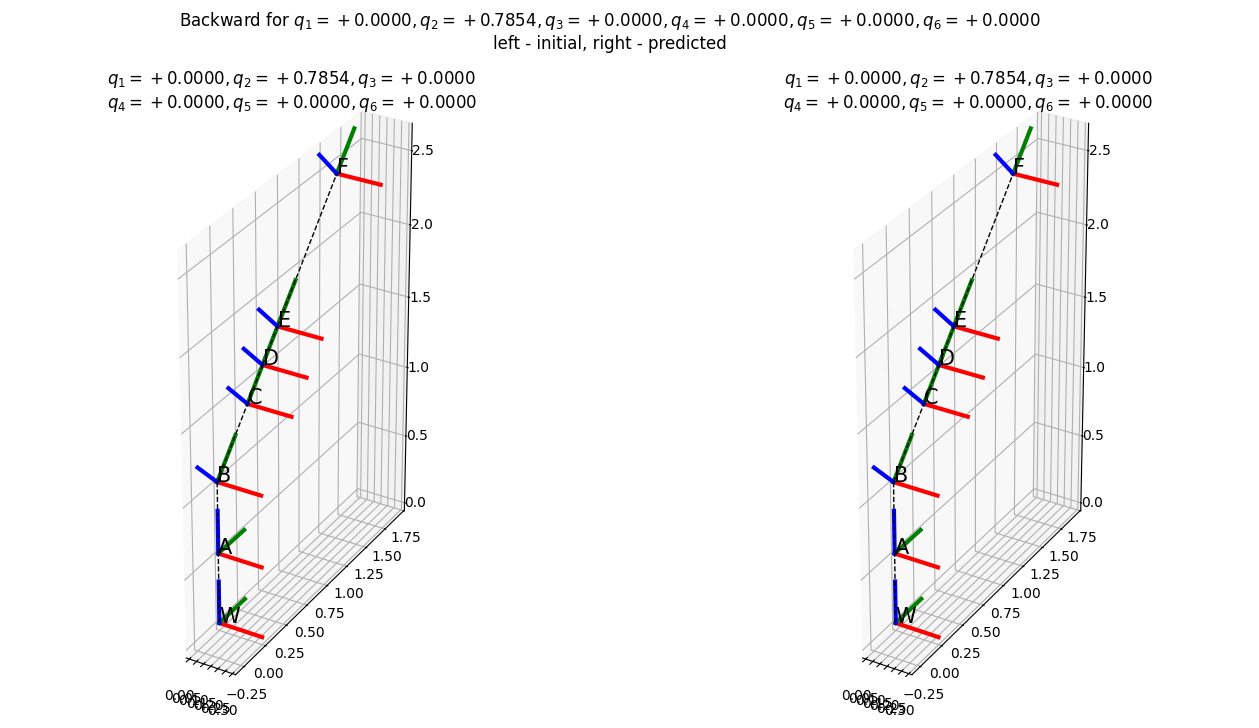

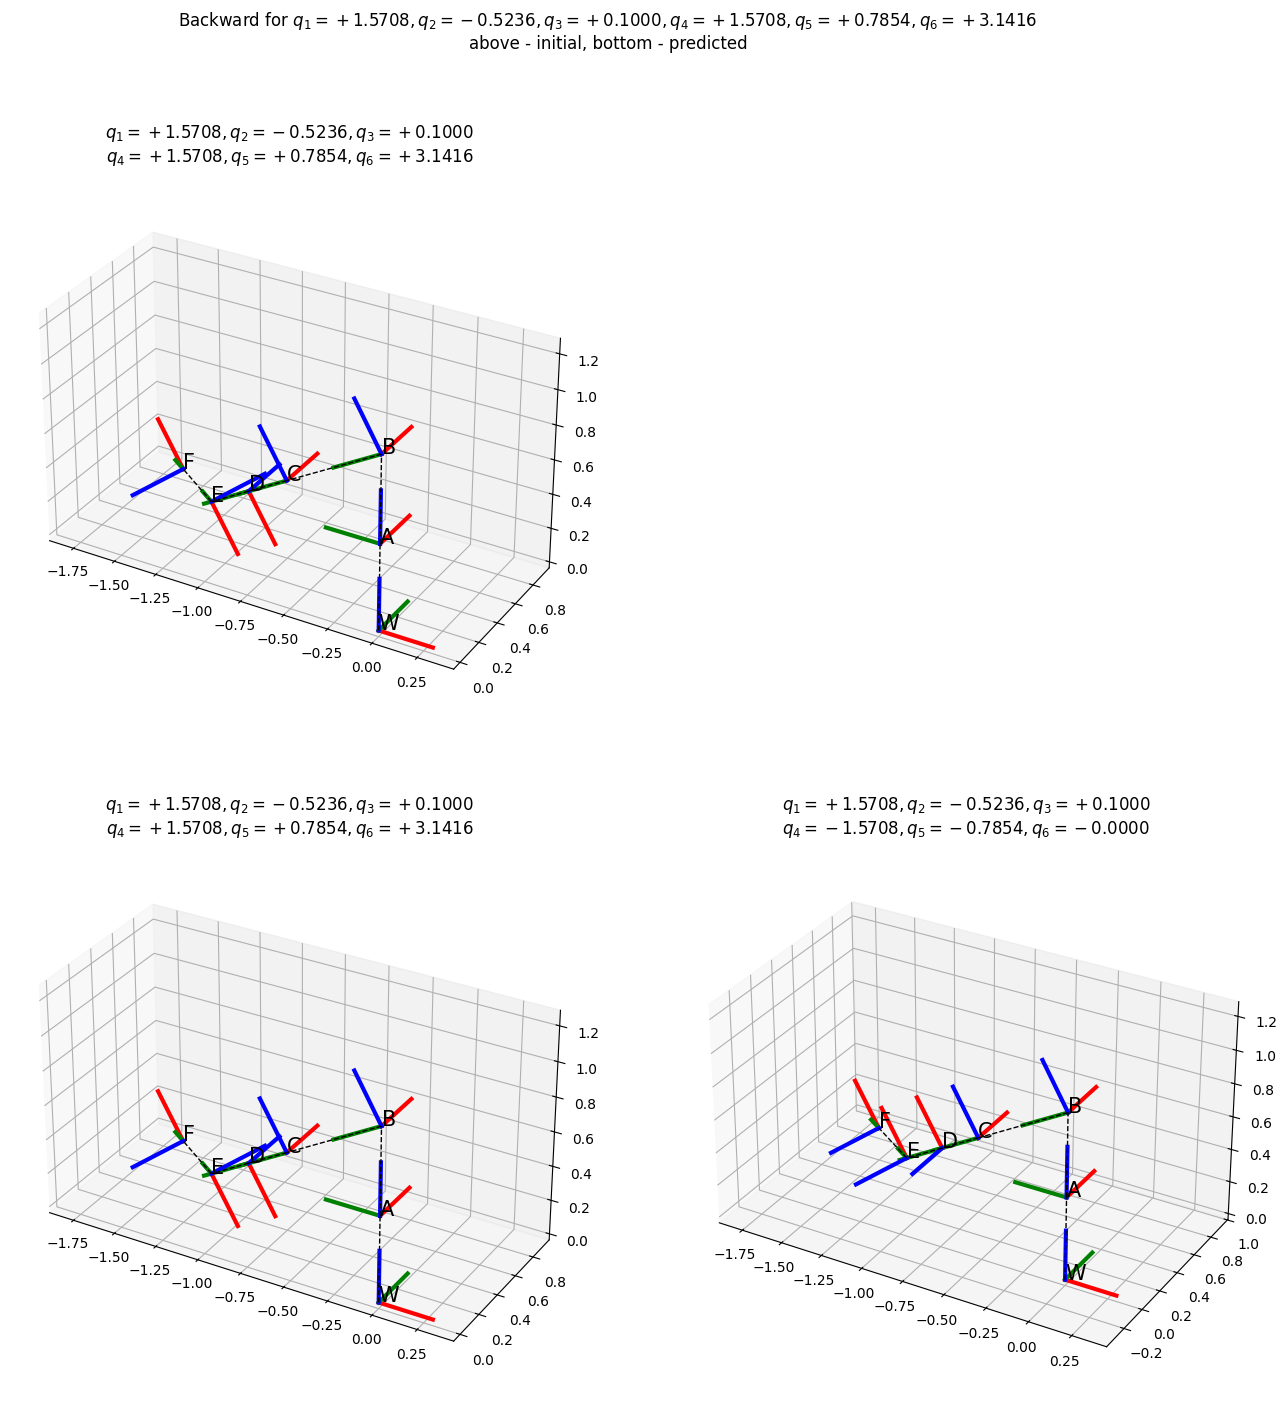

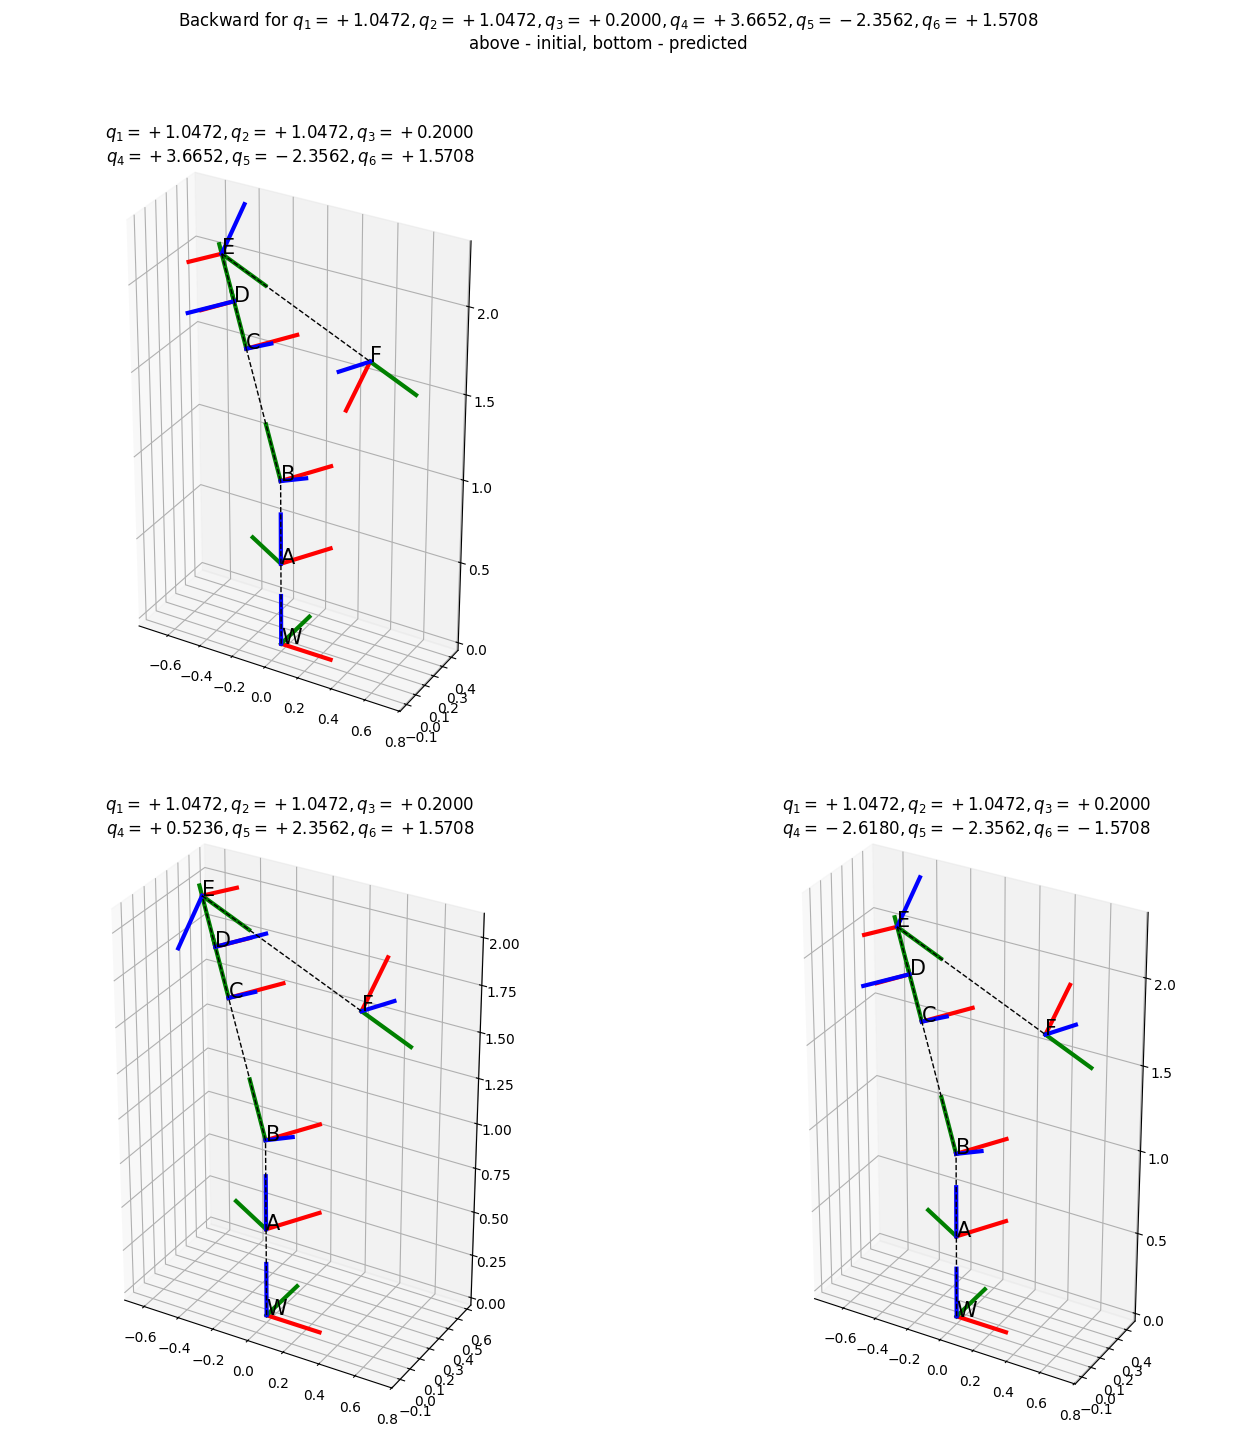

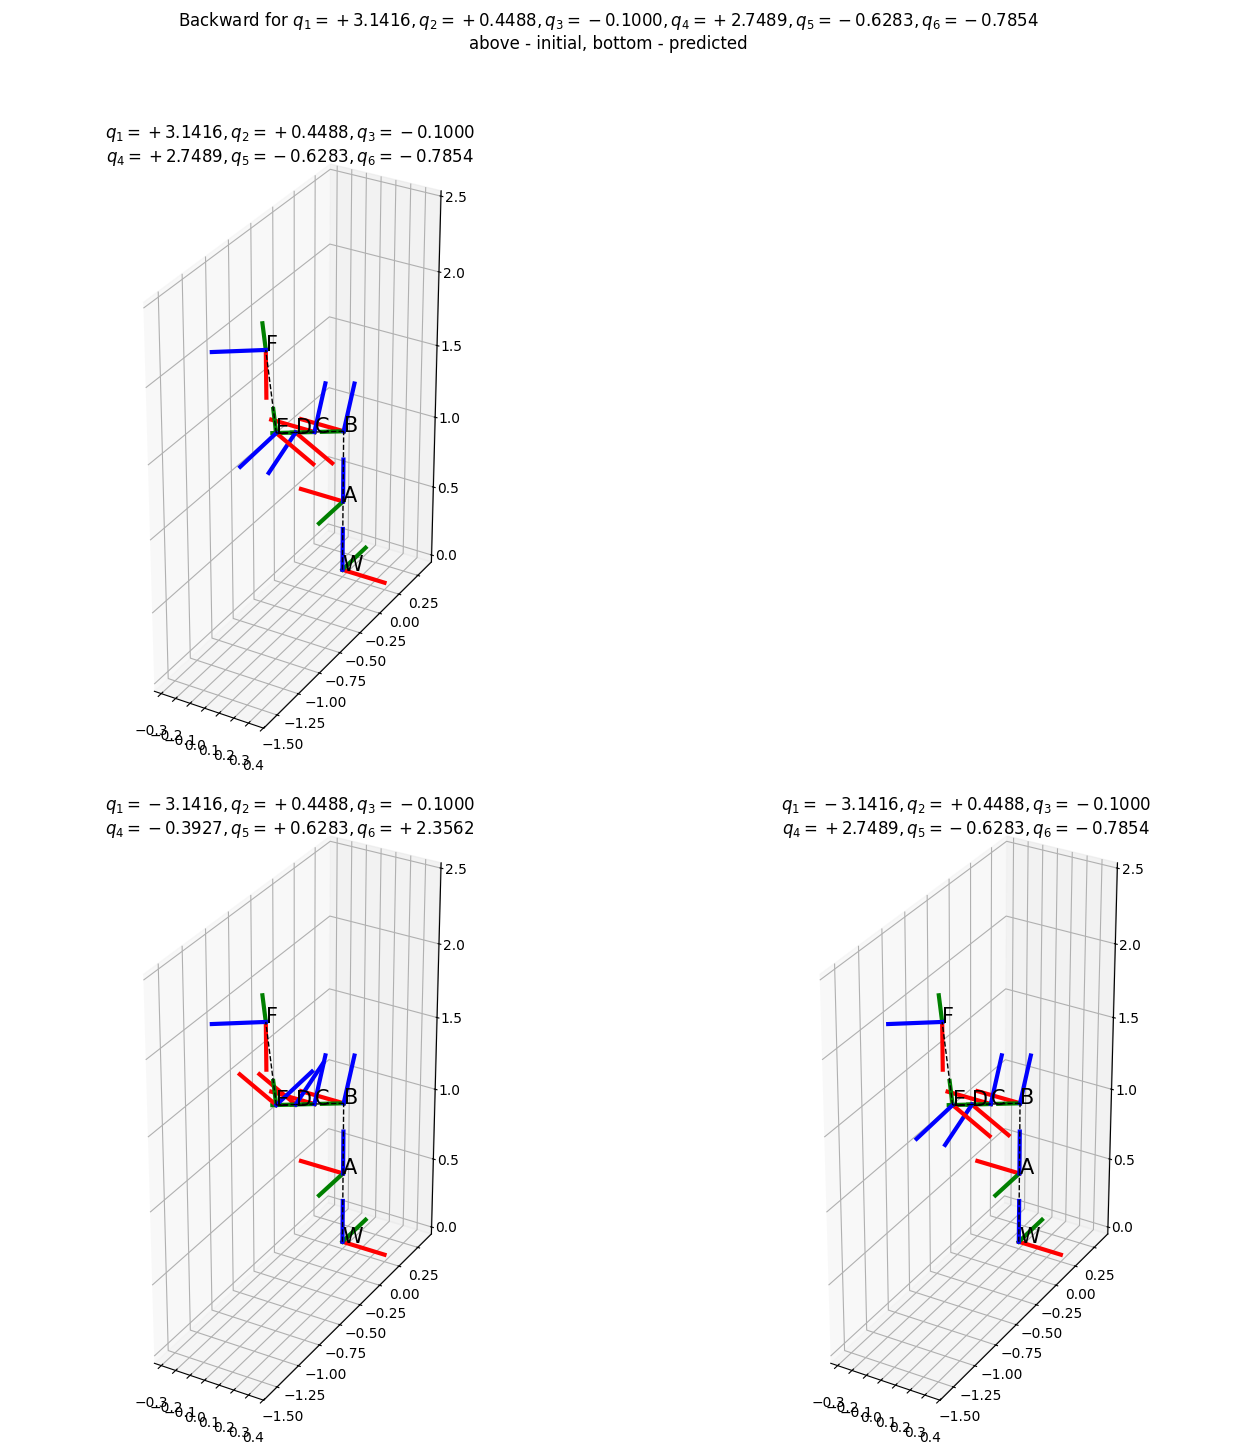

In [132]:
def test_configuration(qs: np.ndarray, save_as: str):
    ts = forward(H_1, H_2, H_3, *qs)
    backward_qs = backward(ts[-1], H_1, H_2, H_3, 0.1 * EPSILON ** 2)
    
    if len(backward_qs) == 1:
        configurations = [qs, backward_qs[0]]
        plot_configurations(
            1, 2, configurations, 
            f"Backward for {configuration2str(qs, False)}\n"
            "left - initial, right - predicted",
            save_as,
            figsize=(16, 8)
        )
    else:
        configurations = [qs, None] + list(backward_qs)
        plot_configurations(
            2, 2, configurations,
            f"Backward for {configuration2str(qs, False)}\n"
            "above - initial, bottom - predicted",
            save_as,
        )

def test_configurations():
    for i, qs in enumerate(CONFIGURATIONS):
        test_configuration(qs, f"backward_{i}.png")

test_configurations()